In [1]:
import pydotplus
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from six import StringIO
from IPython.display import Image  

# preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# metrics
from sklearn.metrics import (
    roc_curve,
    roc_auc_score,
    accuracy_score,
    confusion_matrix
)

# models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.ensemble import RandomForestClassifier
from tensorflow.keras import models, layers, optimizers

# plot styling
plt.style.use('seaborn-darkgrid') # style
plt.rcParams['font.family'] = ' DIN Alternate' # for macintosh use
GLOBAL_FONT_SIZE = 13 
plt.rcParams.update({'font.size': GLOBAL_FONT_SIZE}) # font size
plt_dpi = 100 # resolution

In [2]:
def stacked_bar(grouping, task, width=0.4):
    """ Stacked barplot for different aggregations of the data """
    defaulted = credit_data.groupby(grouping)['BAD'].sum()
    total = credit_data.groupby(grouping)['BAD'].count()
    not_defaulted = total - defaulted
    res = pd.DataFrame(
        {
            'No default': not_defaulted / total,
            'Default': defaulted / total
        },
        index=defaulted.index
    )

    _, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    res.plot.bar(
        stacked=True,
        alpha=.75,
        color = ['green', 'rosybrown'],
        width=width,
        ax=ax1
    )
    ax1.set_ylabel('Proportion')
    ax1.legend(frameon=1, facecolor='white', loc='lower right', framealpha=1)

    data = credit_data.groupby(grouping)[grouping].count()
    data.plot.bar(
        color='green',
        alpha=0.75,
        width=width,
        ax=ax2
    )
    ax2.set_ylabel('Frequency')
    plt.tight_layout()
    plt.savefig(
        f'plots_CA5/{task}.png',
        dpi=plt_dpi,
        bbox_inches='tight')
    plt.show()

### 1. Explore the data

In [3]:
# read data
credit_data = pd.read_csv('data/loan_data.csv')
credit_data.head(10)

,BAD,LOAN,MORTDUE,VALUE,REASON,JOB,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC
0,0,22400,62354.0,88287.0,DebtCon,Office,3.0,NaN,NaN,163.056409,NaN,16.0,37.171396
1,1,10000,65000.0,80000.0,DebtCon,Other,2.0,0.0,0.0,26.366667,3.0,2.0,NaN
2,0,15400,100848.0,129454.0,HomeImp,ProfExe,10.0,0.0,0.0,174.896519,2.0,31.0,28.065591
3,0,8600,38646.0,54073.0,DebtCon,Other,14.0,0.0,0.0,89.555853,0.0,11.0,32.530257
4,0,27700,73148.0,101462.0,DebtCon,ProfExe,10.0,0.0,0.0,264.605389,0.0,33.0,40.475793
5,0,11300,78902.0,100332.0,DebtCon,ProfExe,4.0,0.0,0.0,116.998799,0.0,26.0,34.683071
6,0,8500,50569.0,60940.0,DebtCon,Mgr,6.0,0.0,0.0,189.946898,0.0,22.0,29.202477
7,1,9000,32539.0,65440.0,HomeImp,Office,5.0,NaN,NaN,NaN,NaN,NaN,42.368944
8,0,12300,102908.0,124217.0,HomeImp,ProfExe,9.0,0.0,0.0,159.994026,2.0,31.0,27.707444
9,1,9100,78369.0,92000.0,DebtCon,Sales,0.2,0.0,0.0,180.833333,3.0,35.0,NaN


In [4]:
prob_default = credit_data['BAD'].mean()
print(f'The default probability is {prob_default:.4f}')

The default probability is 0.1995


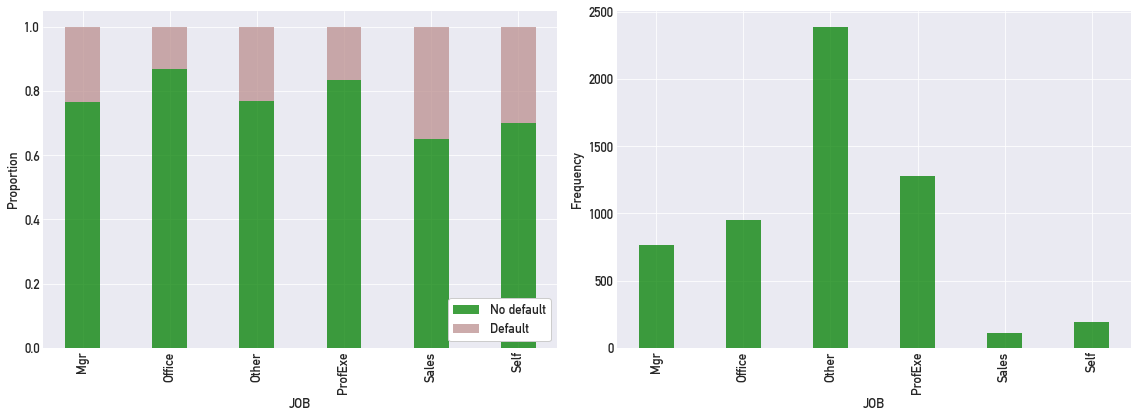

In [5]:
# 1b)
stacked_bar(grouping='JOB', task='1b')

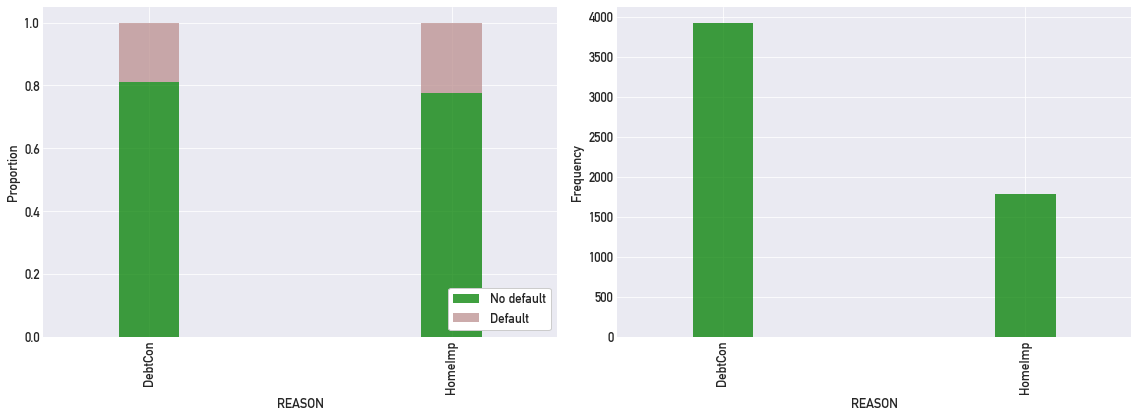

In [6]:
# 1c)
stacked_bar(grouping='REASON', task='1c', width=0.2)

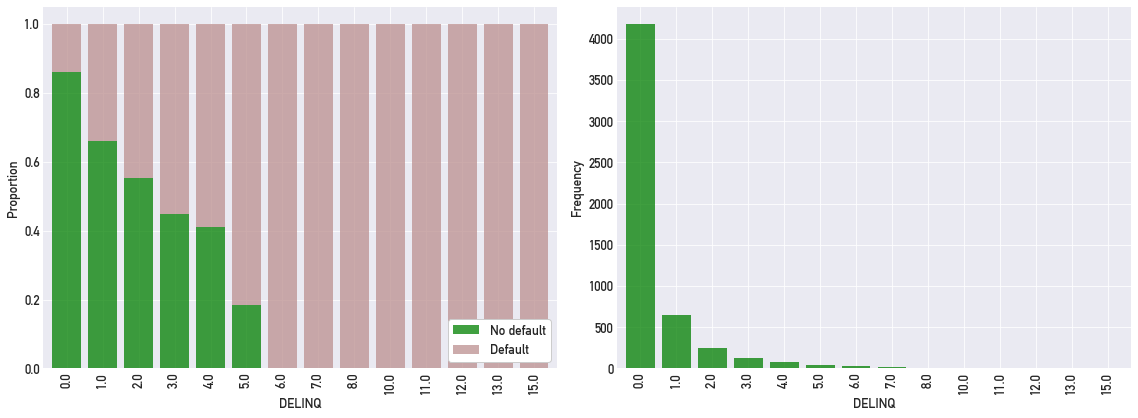

In [7]:
# 1d)
stacked_bar(grouping='DELINQ', task='1d', width=0.8)

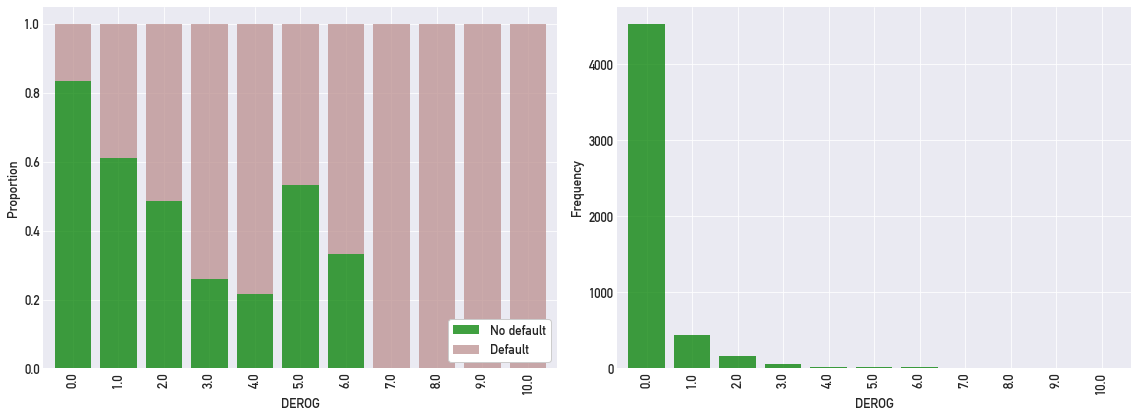

In [8]:
# 1e)
stacked_bar(grouping='DEROG', task='1e', width=0.8)

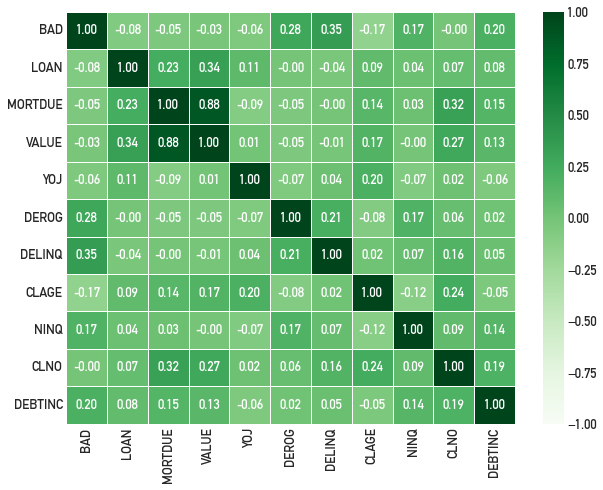

In [9]:
# compute correlation matrix
corr = credit_data.corr()

_, ax = plt.subplots(figsize=(9, 7))
ax = sns.heatmap(
    corr,
    vmin=-1,
    vmax=1,
    cmap='Greens',
    annot=True,
    fmt='.2f', 
    linewidths=.5,
    ax=ax,
    annot_kws={'color': 'white'}
)
plt.savefig('plots_CA5/1f.png', dpi=plt_dpi, bbox_inches='tight')
plt.tight_layout()

### 2. Preprocessing

#### Impute missing values

In [10]:
credit_data.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5960 entries, 0 to 5959
Data columns (total 13 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   BAD      5960 non-null   int64  
 1   LOAN     5960 non-null   int64  
 2   MORTDUE  5442 non-null   float64
 3   VALUE    5848 non-null   float64
 4   REASON   5708 non-null   object 
 5   JOB      5681 non-null   object 
 6   YOJ      5445 non-null   float64
 7   DEROG    5252 non-null   float64
 8   DELINQ   5380 non-null   float64
 9   CLAGE    5652 non-null   float64
 10  NINQ     5450 non-null   float64
 11  CLNO     5738 non-null   float64
 12  DEBTINC  4693 non-null   float64
dtypes: float64(9), int64(2), object(2)
memory usage: 605.4+ KB


In [11]:
# fill NaNs for numerical columns
mean_fill_cols = ['LOAN', 'MORTDUE', 'VALUE', 'CLAGE', 'DEBTINC']
data_mf = credit_data.fillna(
    credit_data.loc[:, mean_fill_cols].mean(axis=0)
)

In [12]:
# fill NaNs for categorical columns
count_fill_cols = ['REASON', 'JOB', 'YOJ', 'DEROG', 'DELINQ', 'NINQ', 'CLNO']
data_mf_cf = data_mf.fillna(
    data_mf.loc[:, count_fill_cols].mode().iloc[0]
)

In [13]:
# verify filling of missing values
data_mf_cf.isnull().sum()

BAD        0
LOAN       0
MORTDUE    0
VALUE      0
REASON     0
JOB        0
YOJ        0
DEROG      0
DELINQ     0
CLAGE      0
NINQ       0
CLNO       0
DEBTINC    0
dtype: int64

In [14]:
# convert categorical to dummies (k-1 variables)
# do each column separately to store the original column names
reason_dummy = pd.get_dummies(data_mf_cf.loc[:, 'REASON'], drop_first=True)
job_dummy = pd.get_dummies(data_mf_cf.loc[:, 'JOB'], drop_first=True)

In [15]:
clean_data = data_mf_cf.drop(['REASON', 'JOB'], axis=1).join(reason_dummy).join(job_dummy)
clean_data

,BAD,LOAN,MORTDUE,VALUE,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC,HomeImp,Office,Other,ProfExe,Sales,Self
0,0,22400,62354.0,88287.0,3.0,0.0,0.0,163.056409,0.0,16.0,37.171396,0,1,0,0,0,0
1,1,10000,65000.0,80000.0,2.0,0.0,0.0,26.366667,3.0,2.0,33.779915,0,0,1,0,0,0
2,0,15400,100848.0,129454.0,10.0,0.0,0.0,174.896519,2.0,31.0,28.065591,1,0,0,1,0,0
3,0,8600,38646.0,54073.0,14.0,0.0,0.0,89.555853,0.0,11.0,32.530257,0,0,1,0,0,0
4,0,27700,73148.0,101462.0,10.0,0.0,0.0,264.605389,0.0,33.0,40.475793,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5955,0,28200,100353.0,131386.0,9.0,0.0,0.0,146.065483,0.0,28.0,38.679208,0,1,0,0,0,0
5956,0,21200,91759.0,95165.0,2.0,0.0,0.0,106.835733,0.0,19.0,34.216689,0,0,0,1,0,0
5957,0,10600,82365.0,100272.0,3.0,1.0,0.0,122.483594,0.0,26.0,33.651647,0,0,0,1,0,0
5958,0,18200,68743.0,92112.0,0.0,0.0,0.0,95.343765,0.0,16.0,26.692667,0,0,0,0,0,0


#### Split into training and test sets

In [16]:
x_train, x_test, y_train, y_test = train_test_split(
    clean_data.drop('BAD', axis=1),
    clean_data['BAD'],
    test_size = 0.2,
    shuffle = False
)

In [17]:
# for report use - 2d)
res_2c_1 = x_train.head(10).round(3).to_latex(
    position='H',
    label='tab:2c-train',
    caption='Caption',
    index=False
)
print(res_2c_1)

# for report use - 2d)
res_2c_2 = x_test.head(10).round(3).to_latex(
    position='H',
    label='tab:2c-test',
    caption='Caption',
    index=False
)
print(res_2c_2)

\begin{table}[H]
\centering
\caption{Caption}
\label{tab:2c-train}
\begin{tabular}{rrrrrrrrrrrrrrrr}
\toprule
 LOAN &  MORTDUE &    VALUE &  YOJ &  DEROG &  DELINQ &   CLAGE &  NINQ &  CLNO &  DEBTINC &  HomeImp &  Office &  Other &  ProfExe &  Sales &  Self \\
\midrule
22400 &  62354.0 &  88287.0 &  3.0 &    0.0 &     0.0 & 163.056 &   0.0 &  16.0 &   37.171 &        0 &       1 &      0 &        0 &      0 &     0 \\
10000 &  65000.0 &  80000.0 &  2.0 &    0.0 &     0.0 &  26.367 &   3.0 &   2.0 &   33.780 &        0 &       0 &      1 &        0 &      0 &     0 \\
15400 & 100848.0 & 129454.0 & 10.0 &    0.0 &     0.0 & 174.897 &   2.0 &  31.0 &   28.066 &        1 &       0 &      0 &        1 &      0 &     0 \\
 8600 &  38646.0 &  54073.0 & 14.0 &    0.0 &     0.0 &  89.556 &   0.0 &  11.0 &   32.530 &        0 &       0 &      1 &        0 &      0 &     0 \\
27700 &  73148.0 & 101462.0 & 10.0 &    0.0 &     0.0 & 264.605 &   0.0 &  33.0 &   40.476 &        0 &       0 &      0 

#### Normalize the data

In [18]:
# use sklearn scaler API
scaler = StandardScaler()
x_train_num = x_train.loc[:, :'DEBTINC']
x_test_num = x_test.loc[:, :'DEBTINC']

x_train_cat = x_train.loc[:, 'HomeImp':]
x_test_cat = x_test.loc[:, 'HomeImp':]

# fit scaler
scaler.fit(x_train_num)

# restore dataframes
x_train_norm_num = pd.DataFrame(
    scaler.transform(x_train_num),
    index=x_train_num.index,
    columns=x_train_num.columns
)
x_test_norm_num = pd.DataFrame(
    scaler.transform(x_test_num),
    index=x_test_num.index,
    columns=x_test_num.columns
)

# merge num and cat parts
x_train_norm = x_train_norm_num.join(x_train_cat)
x_test_norm = x_test_norm_num.join(x_test_cat)

In [19]:
x_train_norm.head(10)

,LOAN,MORTDUE,VALUE,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC,HomeImp,Office,Other,ProfExe,Sales,Self
0,0.351352,-0.270375,-0.238837,-0.681943,-0.2846,-0.372582,-0.200267,-0.649945,-0.510901,0.428920,0,1,0,0,0,0
1,-0.764820,-0.207821,-0.383355,-0.812165,-0.2846,-0.372582,-1.808704,1.126968,-1.910831,-0.006774,0,0,1,0,0,0
2,-0.278745,0.639657,0.479079,0.229610,-0.2846,-0.372582,-0.060944,0.534664,0.989023,-0.740879,1,0,0,1,0,0
3,-0.890839,-0.830853,-0.835498,0.750498,-0.2846,-0.372582,-1.065153,-0.649945,-1.010876,-0.167315,0,0,1,0,0,0
4,0.828426,-0.015195,-0.009076,0.229610,-0.2846,-0.372582,0.994666,-0.649945,1.189013,0.853428,0,0,0,1,0,0
5,-0.647802,0.120834,-0.028783,-0.551721,-0.2846,-0.372582,-0.742230,-0.649945,0.489048,0.109252,0,0,0,1,0,0
6,-0.899840,-0.548983,-0.715744,-0.291277,-0.2846,-0.372582,0.116155,-0.649945,0.089068,-0.594826,0,0,0,0,0,0
7,-0.854834,-0.975228,-0.637268,-0.421499,-0.2846,-0.372582,-0.003641,-0.649945,-0.510901,1.096636,1,1,0,0,0,0
8,-0.557788,0.688357,0.387750,0.099388,-0.2846,-0.372582,-0.236302,0.534664,0.989023,-0.786890,1,0,0,1,0,0
9,-0.845832,0.108234,-0.174085,-1.046564,-0.2846,-0.372582,0.008915,1.126968,1.389003,-0.006774,0,0,0,0,1,0


In [20]:
# for report use - 2d)
res_2d_1 = x_train_norm.head(10).round(3).to_latex(
    position='H',
    label='tab:2d-train',
    caption='Caption',
    index=False
)
print(res_2d_1)

\begin{table}[H]
\centering
\caption{Caption}
\label{tab:2d-train}
\begin{tabular}{rrrrrrrrrrrrrrrr}
\toprule
  LOAN &  MORTDUE &  VALUE &    YOJ &  DEROG &  DELINQ &  CLAGE &   NINQ &   CLNO &  DEBTINC &  HomeImp &  Office &  Other &  ProfExe &  Sales &  Self \\
\midrule
 0.351 &   -0.270 & -0.239 & -0.682 & -0.285 &  -0.373 & -0.200 & -0.650 & -0.511 &    0.429 &        0 &       1 &      0 &        0 &      0 &     0 \\
-0.765 &   -0.208 & -0.383 & -0.812 & -0.285 &  -0.373 & -1.809 &  1.127 & -1.911 &   -0.007 &        0 &       0 &      1 &        0 &      0 &     0 \\
-0.279 &    0.640 &  0.479 &  0.230 & -0.285 &  -0.373 & -0.061 &  0.535 &  0.989 &   -0.741 &        1 &       0 &      0 &        1 &      0 &     0 \\
-0.891 &   -0.831 & -0.835 &  0.750 & -0.285 &  -0.373 & -1.065 & -0.650 & -1.011 &   -0.167 &        0 &       0 &      1 &        0 &      0 &     0 \\
 0.828 &   -0.015 & -0.009 &  0.230 & -0.285 &  -0.373 &  0.995 & -0.650 &  1.189 &    0.853 &        0 &      

In [21]:
x_test_norm.head(10)

,LOAN,MORTDUE,VALUE,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC,HomeImp,Office,Other,ProfExe,Sales,Self
4768,-0.602795,1.046398,0.407073,-0.421499,-0.284600,-0.372582,0.012901,-0.649945,-0.310911,-0.081224,0,0,0,0,0,1
4769,-0.836831,-1.277429,-1.322625,-1.072608,1.007757,-0.372582,-2.113236,4.680794,-1.410856,-0.868105,0,0,1,0,0,0
4770,-0.044709,0.605449,0.662992,0.086366,2.300114,-0.372582,-0.352726,1.126968,-0.110921,-0.006774,0,0,1,0,0,0
4771,-0.503779,-0.650710,-0.697258,-0.161055,-0.284600,-0.372582,-1.211330,2.311577,-0.310911,-0.006774,0,0,1,0,0,0
4772,0.855430,0.525401,0.445892,-1.072608,1.007757,-0.372582,0.193542,1.126968,1.588993,0.133477,0,0,0,1,0,0
4773,0.765416,1.186991,1.046652,-0.968431,-0.284600,1.454122,-0.161315,-0.057640,1.289008,-0.006774,0,0,1,0,0,0
4774,-0.764820,-0.327704,-0.003600,-0.421499,-0.284600,-0.372582,-0.003641,-0.649945,-0.510901,-0.006774,0,0,1,0,0,0
4775,-0.674806,-0.474963,-0.592624,-0.291277,-0.284600,-0.372582,-0.924605,-0.649945,-0.810886,-0.006774,0,0,0,0,0,0
4776,0.603391,-0.520141,-0.460627,2.182938,-0.284600,0.540770,1.198511,-0.057640,0.889028,0.904664,0,0,1,0,0,0
4777,-1.286900,-0.177750,-0.331857,-0.681943,-0.284600,-0.372582,-0.821306,-0.649945,-0.610896,1.235592,1,0,1,0,0,0


In [22]:
# for report use - 2d)
res_2d_2 = x_test_norm.head(10).round(3).to_latex(
    position='H',
    label='tab:2d-test',
    caption='Caption',
    index=False
)
print(res_2d_2)

\begin{table}[H]
\centering
\caption{Caption}
\label{tab:2d-test}
\begin{tabular}{rrrrrrrrrrrrrrrr}
\toprule
  LOAN &  MORTDUE &  VALUE &    YOJ &  DEROG &  DELINQ &  CLAGE &   NINQ &   CLNO &  DEBTINC &  HomeImp &  Office &  Other &  ProfExe &  Sales &  Self \\
\midrule
-0.603 &    1.046 &  0.407 & -0.421 & -0.285 &  -0.373 &  0.013 & -0.650 & -0.311 &   -0.081 &        0 &       0 &      0 &        0 &      0 &     1 \\
-0.837 &   -1.277 & -1.323 & -1.073 &  1.008 &  -0.373 & -2.113 &  4.681 & -1.411 &   -0.868 &        0 &       0 &      1 &        0 &      0 &     0 \\
-0.045 &    0.605 &  0.663 &  0.086 &  2.300 &  -0.373 & -0.353 &  1.127 & -0.111 &   -0.007 &        0 &       0 &      1 &        0 &      0 &     0 \\
-0.504 &   -0.651 & -0.697 & -0.161 & -0.285 &  -0.373 & -1.211 &  2.312 & -0.311 &   -0.007 &        0 &       0 &      1 &        0 &      0 &     0 \\
 0.855 &    0.525 &  0.446 & -1.073 &  1.008 &  -0.373 &  0.194 &  1.127 &  1.589 &    0.133 &        0 &       

### 3. Logistic Regression

In [23]:
def plot_roc(x, x_norm, y, models, task, mode):
    plt.figure(figsize=(12, 6))
    plt.plot([0, 1], [0, 1], 'k--', label='Baseline')
    for i, (model_name, model) in enumerate(models.items()):
        if model_name == 'Logistic Regression':
            y_score = model.predict_proba(x_norm)[:, 1]
        elif model_name[:-4] == 'Neural Net':
            y_score = model.predict(x_norm)
        else:
            y_score = model.predict_proba(x)[:, 1]
        fpr, tpr, _ = roc_curve(y, y_score)
        roc_auc = roc_auc_score(y, y_score)
        plt.plot(
            fpr, tpr,
            label=f'{model_name} (AUC = {roc_auc:0.3f})',
            color=sns.color_palette()[i]
        )
    plt.xlim([-0.02, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(
        bbox_to_anchor=(1., 1.),
        title=f'Model ({mode.lower()})'
    )
    plt.tight_layout()
    plt.savefig(
        f'plots_CA5/{task}_{mode.lower()}_ROC.png',
        dpi=plt_dpi,
        bbox_inches='tight')
    plt.show()

In [24]:
def eval_lr(x_train, x_test, y_train, y_test):
    # fit model
    lr = LogisticRegression()
    lr_fit = lr.fit(x_train, y_train)

    # predictions 
    y_pred_train = lr_fit.predict(x_train)
    y_pred_test = lr_fit.predict(x_test)

    # accuracies
    train_acc = accuracy_score(y_train, y_pred_train)
    test_acc = accuracy_score(y_test, y_pred_test)
    acc = pd.DataFrame(
        {
            'Train': train_acc,
            'Test': test_acc
        },
        index=['Accuracy']
    ).round(3)

    cm_train, cm_test = confusion_matrix(y_train, y_pred_train), confusion_matrix(y_test, y_pred_test)
    cm_train = pd.DataFrame(
        data=cm_train,
        index=['True class (0)', 'True class (1)'],
        columns=['Predicted class (0)','Predicted class (1)']
    ) 
    cm_test = pd.DataFrame(
        data=cm_test,
        index=['True class (0)', 'True class (1)'],
        columns=['Predicted class (0)','Predicted class (1)']
    ) 
    return lr_fit, acc, cm_train, cm_test, lr_fit.coef_

In [25]:
# logistic regression
lr_mdl, lr_acc, lr_cm_train, lr_cm_test, lr_coef = eval_lr(
    x_train_norm,
    x_test_norm,
    y_train,
    y_test
)

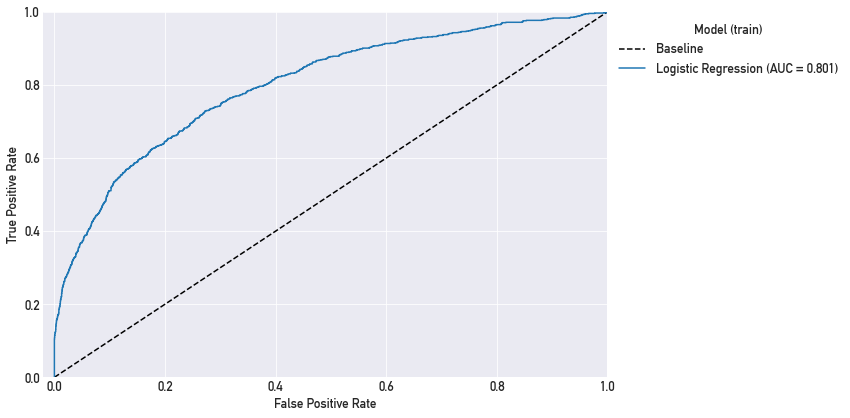

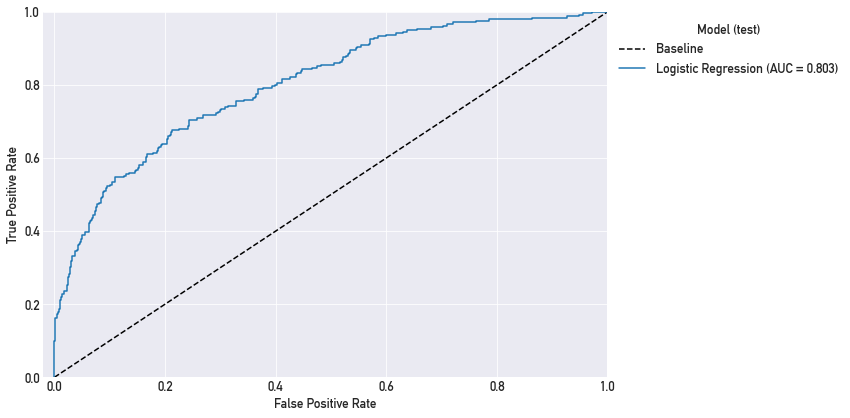

In [26]:
mdls = {
    'Logistic Regression': lr_mdl
}

# train ROC
plot_roc(x_train, x_train_norm, y_train, mdls, task='3', mode='Train')

# test ROC
plot_roc(x_test, x_test_norm, y_test, mdls, task='3', mode='Test')

In [71]:
print(lr_acc.to_latex(position='H', label='tab:3a_acc', caption='Caption'))

\begin{table}[H]
\centering
\caption{Caption}
\label{tab:3a_acc}
\begin{tabular}{lrr}
\toprule
{} &  Train &   Test \\
\midrule
Accuracy &  0.838 &  0.837 \\
\bottomrule
\end{tabular}
\end{table}



In [27]:
lr_cm_train

,Predicted class (0),Predicted class (1)
True class (0),3698,122
True class (1),650,298


In [28]:
lr_cm_test

,Predicted class (0),Predicted class (1)
True class (0),925,26
True class (1),168,73


In [29]:
# for report use 3a)
res_3_cm_train = lr_cm_train.to_latex(
    position='H',
    caption='Caption',
    label='tab:3_cm_train'
)
print(res_3_cm_train)

# for report use 3b)
res_3_cm_test = lr_cm_test.to_latex(
    position='H',
    caption='Caption',
    label='tab:3_cm_test'
)
print(res_3_cm_test)

\begin{table}[H]
\centering
\caption{Caption}
\label{tab:3_cm_train}
\begin{tabular}{lrr}
\toprule
{} &  Predicted class (0) &  Predicted class (1) \\
\midrule
True class (0) &                 3698 &                  122 \\
True class (1) &                  650 &                  298 \\
\bottomrule
\end{tabular}
\end{table}

\begin{table}[H]
\centering
\caption{Caption}
\label{tab:3_cm_test}
\begin{tabular}{lrr}
\toprule
{} &  Predicted class (0) &  Predicted class (1) \\
\midrule
True class (0) &                  925 &                   26 \\
True class (1) &                  168 &                   73 \\
\bottomrule
\end{tabular}
\end{table}



#### Visualize parameters in the model

In [30]:
lr_params = pd.DataFrame(
    {
        'Parameters': lr_coef.flatten(),
    },
    index=x_train_norm.columns
)
lr_params

,Parameters
LOAN,-0.223585
MORTDUE,-0.167327
VALUE,0.207832
YOJ,-0.069725
DEROG,0.473599
DELINQ,0.822955
CLAGE,-0.459205
NINQ,0.295173
CLNO,-0.179274
DEBTINC,0.369112


In [31]:
res_3_params = lr_params.to_latex(
    position='H',
    caption='Caption',
    label='tab:3_params'
)
print(res_3_params)

\begin{table}[H]
\centering
\caption{Caption}
\label{tab:3_params}
\begin{tabular}{lr}
\toprule
{} &  Parameters \\
\midrule
LOAN    &   -0.223585 \\
MORTDUE &   -0.167327 \\
VALUE   &    0.207832 \\
YOJ     &   -0.069725 \\
DEROG   &    0.473599 \\
DELINQ  &    0.822955 \\
CLAGE   &   -0.459205 \\
NINQ    &    0.295173 \\
CLNO    &   -0.179274 \\
DEBTINC &    0.369112 \\
HomeImp &    0.277997 \\
Office  &   -0.413430 \\
Other   &    0.080166 \\
ProfExe &    0.089198 \\
Sales   &    1.062392 \\
Self    &    0.588520 \\
\bottomrule
\end{tabular}
\end{table}



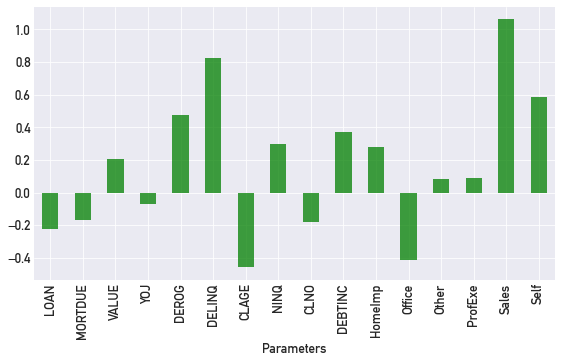

In [32]:
# visualize trained parameters
lr_params.plot.bar(
    figsize=(8, 5),
    color='green',
    alpha=0.75,
    legend=False
)
plt.tight_layout()
plt.xlabel('Parameters')
plt.savefig(
    f'plots_CA5/3_params.png',
    dpi=plt_dpi,
    bbox_inches='tight')
plt.show()

### 4. Decision Trees

In [33]:
def eval_dtc(x_train, x_test, y_train, y_test, max_depth=4):
    # fit model
    dtc = DecisionTreeClassifier(max_depth=max_depth)
    dtc_fit = dtc.fit(x_train, y_train)

    # predictions 
    y_pred_train = dtc_fit.predict(x_train)
    y_pred_test = dtc_fit.predict(x_test)

    # accuracies
    train_acc = accuracy_score(y_train, y_pred_train)
    test_acc = accuracy_score(y_test, y_pred_test)
    acc = pd.DataFrame(
        {
            'Train': train_acc,
            'Test': test_acc
        },
        index=['Accuracy']
    ).round(3)

    cm_train, cm_test = confusion_matrix(y_train, y_pred_train), confusion_matrix(y_test, y_pred_test)
    cm_train = pd.DataFrame(
        data=cm_train,
        index=['True class (0)', 'True class (1)'],
        columns=['Predicted class (0)','Predicted class (1)']
    ) 
    cm_test = pd.DataFrame(
        data=cm_test,
        index=['True class (0)', 'True class (1)'],
        columns=['Predicted class (0)','Predicted class (1)']
    ) 
    return dtc_fit, acc, cm_train, cm_test

In [34]:
# decision tree
dtc_mdl, dtc_acc, dtc_cm_train, dtc_cm_test = eval_dtc(
    x_train,
    x_test,
    y_train,
    y_test
)

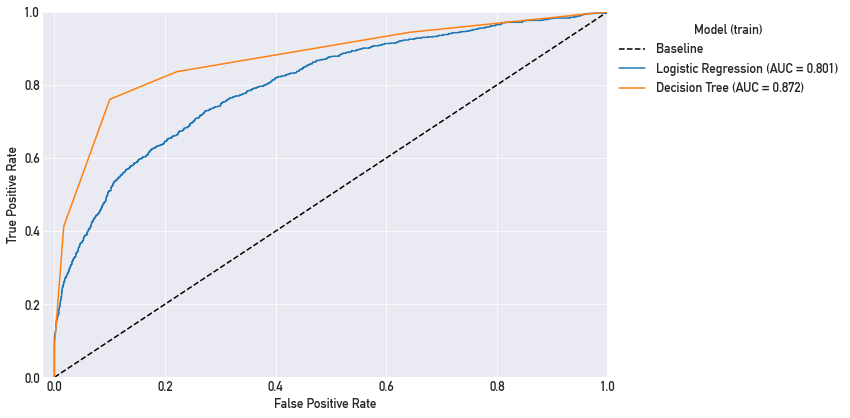

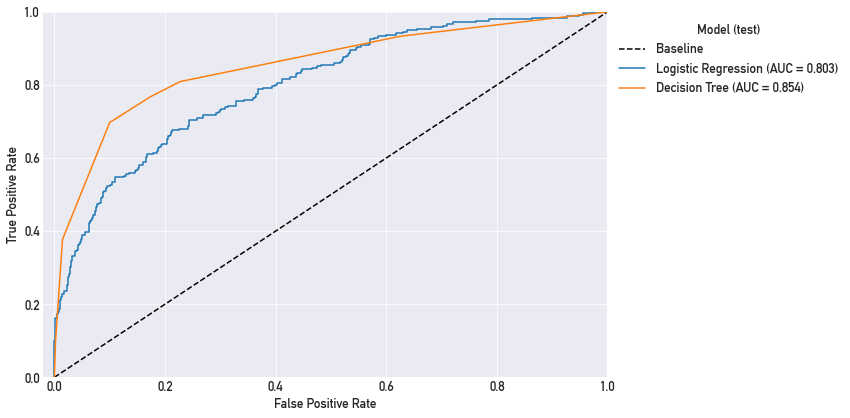

In [35]:
mdls['Decision Tree'] = dtc_mdl

# train ROC
plot_roc(x_train, x_train_norm, y_train, mdls, task='4', mode='Train')

# test ROC
plot_roc(x_test, x_test_norm, y_test, mdls, task='4', mode='Test')

In [74]:
print(dtc_acc.to_latex(position='H', label='tab:4a_acc', caption='Caption'))

\begin{table}[H]
\centering
\caption{Caption}
\label{tab:4a_acc}
\begin{tabular}{lrr}
\toprule
{} &  Train &   Test \\
\midrule
Accuracy &  0.872 &  0.859 \\
\bottomrule
\end{tabular}
\end{table}



In [36]:
dtc_cm_train

,Predicted class (0),Predicted class (1)
True class (0),3439,381
True class (1),229,719


In [37]:
dtc_cm_test

,Predicted class (0),Predicted class (1)
True class (0),857,94
True class (1),74,167


In [38]:
# for report use 4a)
res_4_dtc_train = dtc_cm_train.to_latex(
    position='H',
    caption='Caption',
    label='tab:4_dtc_train'
)
print(res_4_dtc_train)

# for report use 4b)
res_4_dtc_test = dtc_cm_test.to_latex(
    position='H',
    caption='Caption',
    label='tab:4_dtc_test'
)
print(res_4_dtc_test)

\begin{table}[H]
\centering
\caption{Caption}
\label{tab:4_dtc_train}
\begin{tabular}{lrr}
\toprule
{} &  Predicted class (0) &  Predicted class (1) \\
\midrule
True class (0) &                 3439 &                  381 \\
True class (1) &                  229 &                  719 \\
\bottomrule
\end{tabular}
\end{table}

\begin{table}[H]
\centering
\caption{Caption}
\label{tab:4_dtc_test}
\begin{tabular}{lrr}
\toprule
{} &  Predicted class (0) &  Predicted class (1) \\
\midrule
True class (0) &                  857 &                   94 \\
True class (1) &                   74 &                  167 \\
\bottomrule
\end{tabular}
\end{table}



#### Visualize the decision tree

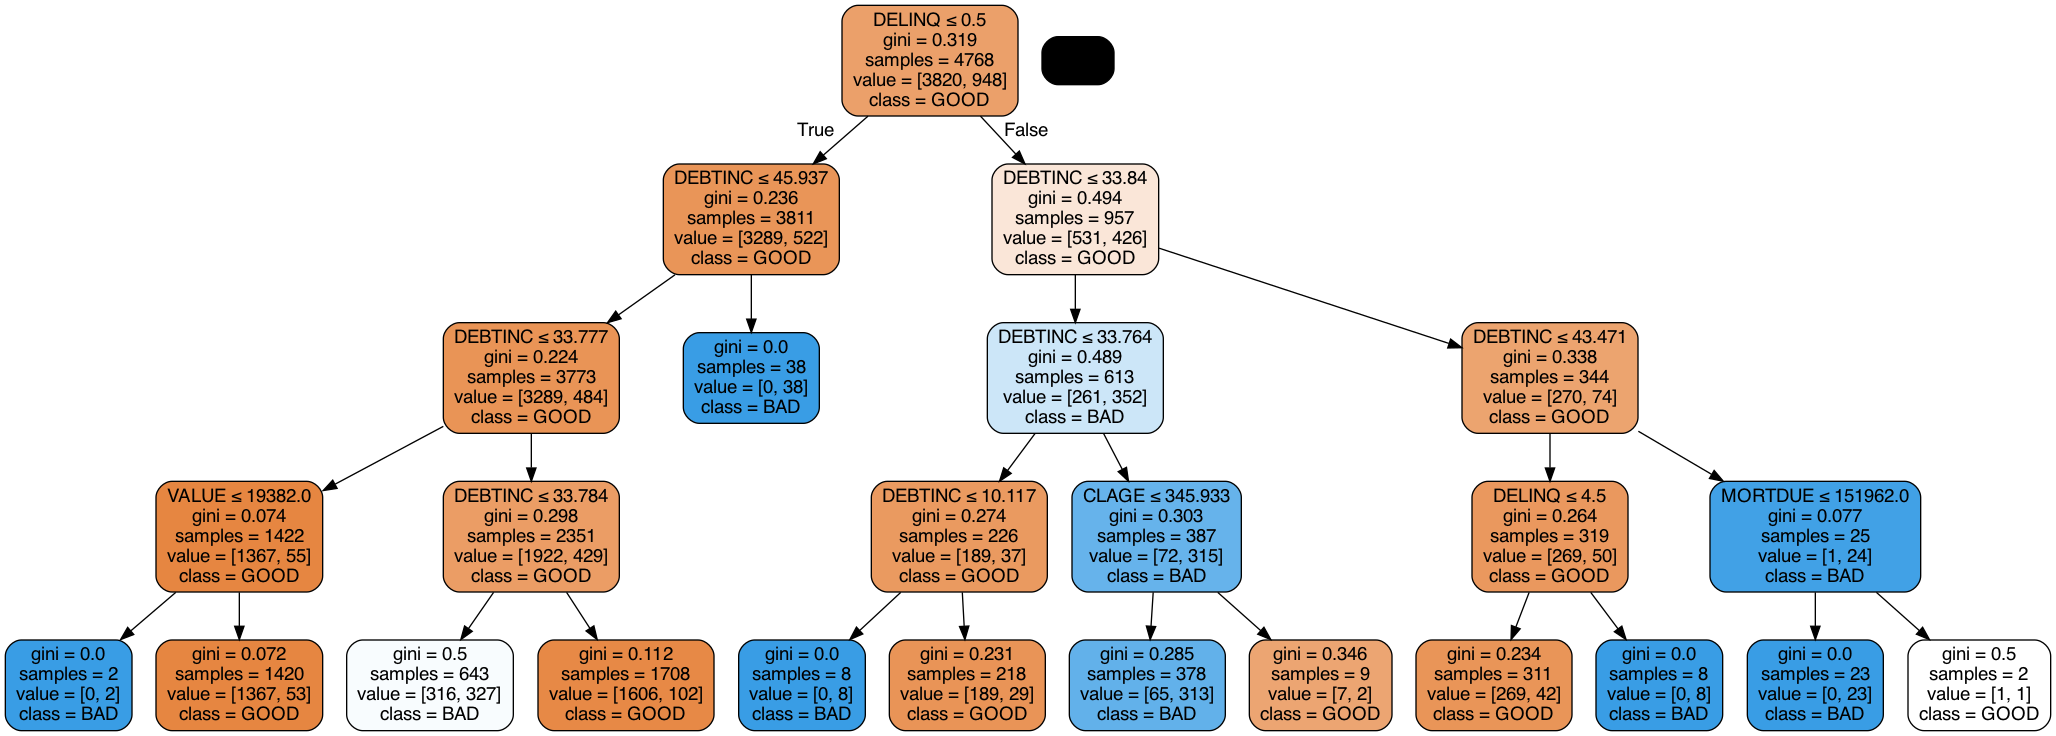

In [39]:
feature_cols = x_train.columns
dot_data = StringIO()
export_graphviz(
    dtc_mdl, out_file=dot_data,  
    filled=True, rounded=True,
    special_characters=True,
    feature_names=feature_cols,
    class_names=['GOOD','BAD']
)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
graph.write_png('plots_CA5/4c_dtc.png')
Image(graph.create_png())

### 5. Random Forest

In [40]:
def eval_rf(x_train, x_test, y_train, y_test, n_estimators):
    # fit model
    rf = RandomForestClassifier(max_depth=8, n_estimators=n_estimators)
    rf_fit = rf.fit(x_train, y_train)

    # predictions 
    y_pred_train = rf_fit.predict(x_train)
    y_pred_test = rf_fit.predict(x_test)

    # accuracies
    train_acc = accuracy_score(y_train, y_pred_train)
    test_acc = accuracy_score(y_test, y_pred_test)
    acc = pd.DataFrame(
        {
            'Train': train_acc,
            'Test': test_acc
        },
        index=['Accuracy']
    ).round(3)

    cm_train, cm_test = confusion_matrix(y_train, y_pred_train), confusion_matrix(y_test, y_pred_test)
    cm_train = pd.DataFrame(
        data=cm_train,
        index=['True class (0)', 'True class (1)'],
        columns=['Predicted class (0)','Predicted class (1)']
    ) 
    cm_test = pd.DataFrame(
        data=cm_test,
        index=['True class (0)', 'True class (1)'],
        columns=['Predicted class (0)','Predicted class (1)']
    ) 
    return rf_fit, acc, cm_train, cm_test

In [41]:
# decision tree - 20 estimators
rf_mdl_20, rf_acc_20, rf_cm_train_20, rf_cm_test_20 = eval_rf(
    x_train,
    x_test,
    y_train,
    y_test,
    n_estimators=20
)

In [42]:
# decision tree - 200 estimators
rf_mdl_200, rf_acc_200, rf_cm_train_200, rf_cm_test_200 = eval_rf(
    x_train,
    x_test,
    y_train,
    y_test,
    n_estimators=200
)

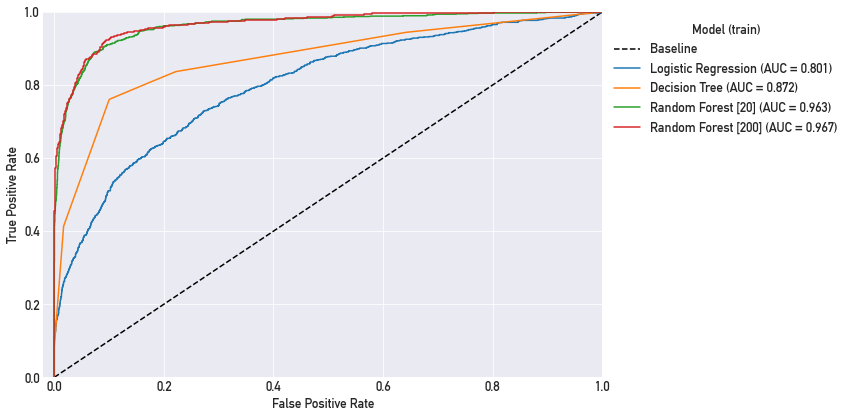

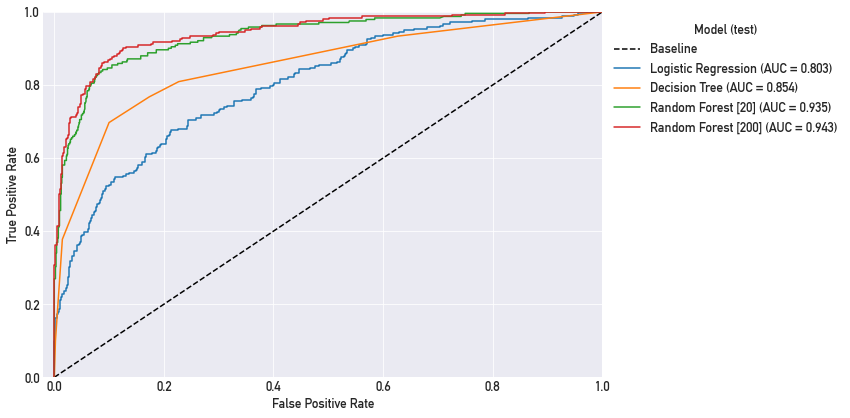

In [43]:
mdls['Random Forest [20]'] = rf_mdl_20
mdls['Random Forest [200]'] = rf_mdl_200
    
# train ROC
plot_roc(x_train, x_train_norm, y_train, mdls, task='5', mode='Train')

# test ROC
plot_roc(x_test, x_test_norm, y_test, mdls, task='5', mode='Test')

In [75]:
print(rf_acc_20.to_latex(position='H', label='tab:5a_acc', caption='Caption'))
print(rf_acc_200.to_latex(position='H', label='tab:5a_acc', caption='Caption'))

\begin{table}[H]
\centering
\caption{Caption}
\label{tab:5a_acc}
\begin{tabular}{lrr}
\toprule
{} &  Train &   Test \\
\midrule
Accuracy &  0.919 &  0.889 \\
\bottomrule
\end{tabular}
\end{table}

\begin{table}[H]
\centering
\caption{Caption}
\label{tab:5a_acc}
\begin{tabular}{lrr}
\toprule
{} &  Train &   Test \\
\midrule
Accuracy &  0.922 &  0.891 \\
\bottomrule
\end{tabular}
\end{table}



In [44]:
rf_cm_train_20

,Predicted class (0),Predicted class (1)
True class (0),3781,39
True class (1),348,600


In [45]:
rf_cm_test_20

,Predicted class (0),Predicted class (1)
True class (0),940,11
True class (1),121,120


In [46]:
rf_cm_train_200

,Predicted class (0),Predicted class (1)
True class (0),3801,19
True class (1),355,593


In [47]:
rf_cm_test_200

,Predicted class (0),Predicted class (1)
True class (0),942,9
True class (1),121,120


In [48]:
# for report use 5a)
res_5_rf_train_20 = rf_cm_train_20.to_latex(
    position='H',
    caption='Caption',
    label='tab:5_rf-20_train'
)
print(res_5_rf_train_20)

# for report use 5b)
res_5_rf_test_20 = rf_cm_test_20.to_latex(
    position='H',
    caption='Caption',
    label='tab:5_rf-20_test'
)
print(res_5_rf_test_20)

\begin{table}[H]
\centering
\caption{Caption}
\label{tab:5_rf-20_train}
\begin{tabular}{lrr}
\toprule
{} &  Predicted class (0) &  Predicted class (1) \\
\midrule
True class (0) &                 3781 &                   39 \\
True class (1) &                  348 &                  600 \\
\bottomrule
\end{tabular}
\end{table}

\begin{table}[H]
\centering
\caption{Caption}
\label{tab:5_rf-20_test}
\begin{tabular}{lrr}
\toprule
{} &  Predicted class (0) &  Predicted class (1) \\
\midrule
True class (0) &                  940 &                   11 \\
True class (1) &                  121 &                  120 \\
\bottomrule
\end{tabular}
\end{table}



In [49]:
# for report use 5a)
res_5_rf_train_200 = rf_cm_train_200.to_latex(
    position='H',
    caption='Caption',
    label='tab:5_rf-200_train'
)
print(res_5_rf_train_200)

# for report use 5b)
res_5_rf_test_200 = rf_cm_test_200.to_latex(
    position='H',
    caption='Caption',
    label='tab:5_rf-200_test'
)
print(res_5_rf_test_200)

\begin{table}[H]
\centering
\caption{Caption}
\label{tab:5_rf-200_train}
\begin{tabular}{lrr}
\toprule
{} &  Predicted class (0) &  Predicted class (1) \\
\midrule
True class (0) &                 3801 &                   19 \\
True class (1) &                  355 &                  593 \\
\bottomrule
\end{tabular}
\end{table}

\begin{table}[H]
\centering
\caption{Caption}
\label{tab:5_rf-200_test}
\begin{tabular}{lrr}
\toprule
{} &  Predicted class (0) &  Predicted class (1) \\
\midrule
True class (0) &                  942 &                    9 \\
True class (1) &                  121 &                  120 \\
\bottomrule
\end{tabular}
\end{table}



### 6. Neural Networks

In [50]:
def eval_nn(model, x_train, x_test, y_train, y_test):
    # predictions 
    y_pred_train = np.round(model.predict(x_train))
    y_pred_test = np.round(model.predict(x_test))

    # accuracies
    train_acc = accuracy_score(y_train, y_pred_train)
    test_acc = accuracy_score(y_test, y_pred_test)
    acc = pd.DataFrame(
        {
            'Train': train_acc,
            'Test': test_acc
        },
        index=['Accuracy']
    ).round(3)

    cm_train, cm_test = confusion_matrix(y_train, y_pred_train), confusion_matrix(y_test, y_pred_test)
    cm_train = pd.DataFrame(
        data=cm_train,
        index=['True class (0)', 'True class (1)'],
        columns=['Predicted class (0)','Predicted class (1)']
    ) 
    cm_test = pd.DataFrame(
        data=cm_test,
        index=['True class (0)', 'True class (1)'],
        columns=['Predicted class (0)','Predicted class (1)']
    ) 
    return acc, cm_train, cm_test

In [51]:
def plot_val_acc(result, model, mode):
    _, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))
    ax1.plot(result.history['loss'], label='Training Loss')
    ax1.plot(result.history['val_loss'], label='Validation Loss')
    ax1.legend(frameon=1, loc='upper right', facecolor='white', title='Metric')
    ax1.set_title(model)

    ax2.plot(result.history['accuracy'], label='Training Accuracy')
    ax2.plot(result.history['val_accuracy'], label='Validation Accuracy')
    ax2.legend(frameon=1, loc='lower right', facecolor='white', title='Metric')

    plt.tight_layout()
    plt.savefig(
        f'plots_CA5/6_loss_acc_{mode}_ROC.png',
        dpi=plt_dpi,
        bbox_inches='tight')
    plt.show()

In [52]:
def compile_fit(model, x_train, y_train, batch_size, patience, epochs=2000):
    # compile model
    model.compile(
        optimizer=optimizers.RMSprop(), 
        loss='binary_crossentropy', 
        metrics=['accuracy']
    )

    # early stopping
    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=patience,
        min_delta=0.001,
        restore_best_weights=True,
        verbose=1
    )

    # fit model
    history = model.fit(
        x_train.values,
        y_train.values,
        validation_split=0.25,
        epochs=epochs,
        batch_size=batch_size, 
        shuffle=False,
        callbacks=[early_stopping]
    )
    return history

#### Build model 1

In [53]:
# build model
model_1 = models.Sequential(name='model_1')
model_1.add(
    layers.Dense(
        20, activation='relu',
        input_shape=(x_train_norm.shape[1], )
    )
)
model_1.add(layers.Dense(1, activation='sigmoid'))
model_1.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 20)                340       
                                                                 
 dense_1 (Dense)             (None, 1)                 21        
                                                                 
Total params: 361
Trainable params: 361
Non-trainable params: 0
_________________________________________________________________


2021-12-22 16:25:20.052685: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [54]:
result_1 = compile_fit(
    model_1,
    x_train_norm,
    y_train,
    batch_size=1192,
    patience=50,
    epochs=2000
)

Epoch 1/2000
3/3 [==============================] - 1s 76ms/step - loss: 0.8917 - accuracy: 0.3054 - val_loss: 0.8435 - val_accuracy: 0.3289
Epoch 2/2000
3/3 [==============================] - 0s 9ms/step - loss: 0.8452 - accuracy: 0.3490 - val_loss: 0.8108 - val_accuracy: 0.3674
Epoch 3/2000
3/3 [==============================] - 0s 9ms/step - loss: 0.8150 - accuracy: 0.3839 - val_loss: 0.7853 - val_accuracy: 0.4027
Epoch 4/2000
3/3 [==============================] - 0s 9ms/step - loss: 0.7904 - accuracy: 0.4102 - val_loss: 0.7635 - val_accuracy: 0.4262
Epoch 5/2000
3/3 [==============================] - 0s 10ms/step - loss: 0.7691 - accuracy: 0.4360 - val_loss: 0.7442 - val_accuracy: 0.4547
Epoch 6/2000
3/3 [==============================] - 0s 9ms/step - loss: 0.7500 - accuracy: 0.4525 - val_loss: 0.7266 - val_accuracy: 0.4815
Epoch 7/2000
3/3 [==============================] - 0s 11ms/step - loss: 0.7326 - accuracy: 0.4779 - val_loss: 0.7104 - val_accuracy: 0.5000
Epoch 8/2000
3/3 

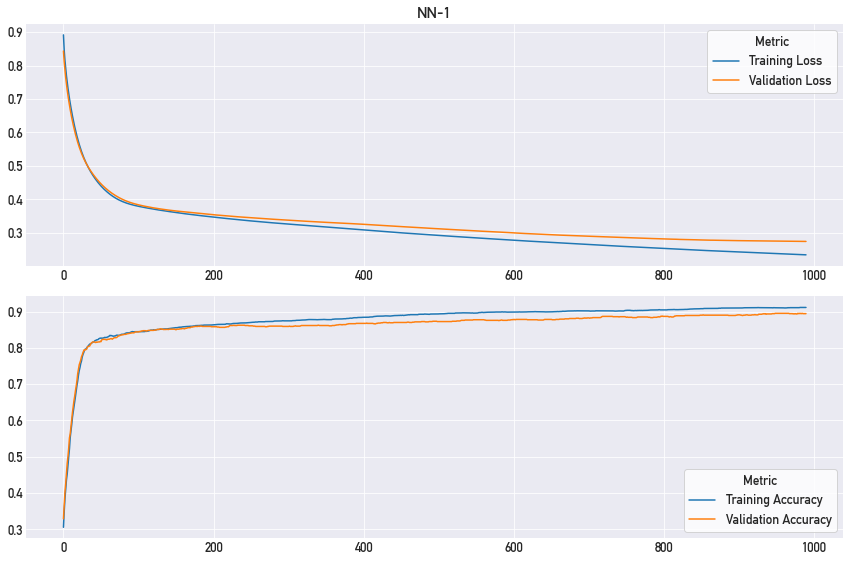

In [55]:
# model 1
plot_val_acc(result_1, model='Neural Net [1]', mode='NN1')

#### Build model 2

In [56]:
# build model 2
model_2 = models.Sequential(name='model_2')
model_2.add(
    layers.Dense(
        50, activation='relu',
        input_shape=(x_train_norm.shape[1], )
    )
)
model_2.add(layers.Dense(20, activation='relu'))
model_2.add(layers.Dense(1, activation='sigmoid'))
model_2.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 50)                850       
                                                                 
 dense_3 (Dense)             (None, 20)                1020      
                                                                 
 dense_4 (Dense)             (None, 1)                 21        
                                                                 
Total params: 1,891
Trainable params: 1,891
Non-trainable params: 0
_________________________________________________________________


In [57]:
result_2 = compile_fit(
    model_2,
    x_train_norm,
    y_train,
    batch_size=1192,
    patience=50,
    epochs=2000
)

Epoch 1/2000
3/3 [==============================] - 1s 55ms/step - loss: 0.6532 - accuracy: 0.6566 - val_loss: 0.6149 - val_accuracy: 0.7500
Epoch 2/2000
3/3 [==============================] - 0s 10ms/step - loss: 0.5957 - accuracy: 0.7760 - val_loss: 0.5831 - val_accuracy: 0.7861
Epoch 3/2000
3/3 [==============================] - 0s 9ms/step - loss: 0.5652 - accuracy: 0.8034 - val_loss: 0.5609 - val_accuracy: 0.8020
Epoch 4/2000
3/3 [==============================] - 0s 10ms/step - loss: 0.5432 - accuracy: 0.8079 - val_loss: 0.5433 - val_accuracy: 0.8020
Epoch 5/2000
3/3 [==============================] - 0s 9ms/step - loss: 0.5254 - accuracy: 0.8126 - val_loss: 0.5282 - val_accuracy: 0.8070
Epoch 6/2000
3/3 [==============================] - 0s 11ms/step - loss: 0.5103 - accuracy: 0.8163 - val_loss: 0.5150 - val_accuracy: 0.8104
Epoch 7/2000
3/3 [==============================] - 0s 15ms/step - loss: 0.4972 - accuracy: 0.8205 - val_loss: 0.5031 - val_accuracy: 0.8180
Epoch 8/2000
3/

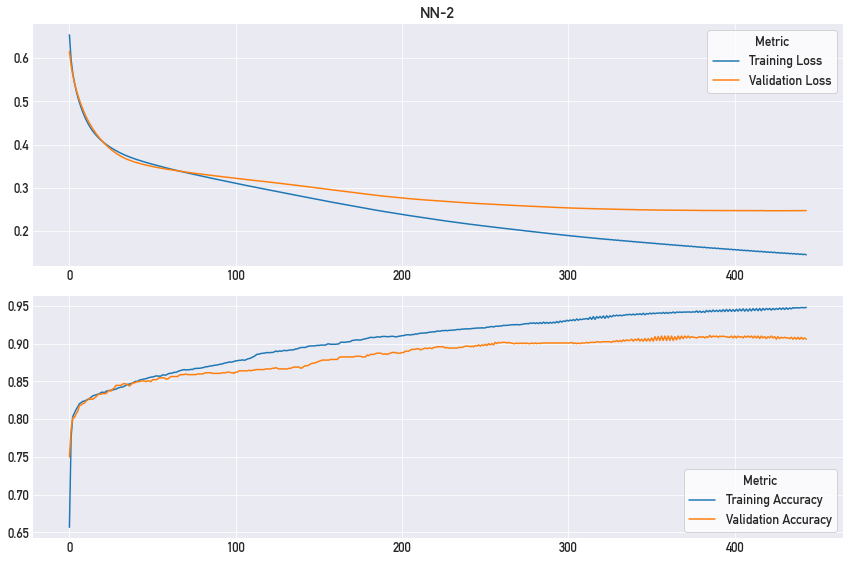

In [58]:
# model 2
plot_val_acc(result_2, model='Neural Net [2]', mode='NN2')

#### Evaluate models

In [59]:
# evaluate model 1
nn_acc_1, nn_cm_train_1, nn_cm_test_1 = eval_nn(
    model_1,
    x_train_norm,
    x_test_norm,
    y_train,
    y_test
)

# evaluate model 1
nn_acc_2, nn_cm_train_2, nn_cm_test_2 = eval_nn(
    model_2,
    x_train_norm,
    x_test_norm,
    y_train,
    y_test
)

#### Model 1

In [76]:
print(nn_acc_1.to_latex(position='H', label='tab:6a_acc', caption='Caption'))

\begin{table}[H]
\centering
\caption{Caption}
\label{tab:6a_acc}
\begin{tabular}{lrr}
\toprule
{} &  Train &   Test \\
\midrule
Accuracy &  0.906 &  0.888 \\
\bottomrule
\end{tabular}
\end{table}



In [60]:
nn_acc_1

,Train,Test
Accuracy,0.906,0.888


In [61]:
nn_cm_train_1

,Predicted class (0),Predicted class (1)
True class (0),3735,85
True class (1),361,587


In [62]:
nn_cm_test_1

,Predicted class (0),Predicted class (1)
True class (0),936,15
True class (1),118,123


In [63]:
# for report use 6a)
res_6_nn_train_1 = nn_cm_train_1.to_latex(
    position='H',
    caption='Caption',
    label='tab:6_nn-1_train'
)
print(res_6_nn_train_1)

# for report use 6b)
res_6_nn_test_1 = nn_cm_test_1.to_latex(
    position='H',
    caption='Caption',
    label='tab:5_nn-1_test'
)
print(res_6_nn_test_1)

\begin{table}[H]
\centering
\caption{Caption}
\label{tab:6_nn-1_train}
\begin{tabular}{lrr}
\toprule
{} &  Predicted class (0) &  Predicted class (1) \\
\midrule
True class (0) &                 3735 &                   85 \\
True class (1) &                  361 &                  587 \\
\bottomrule
\end{tabular}
\end{table}

\begin{table}[H]
\centering
\caption{Caption}
\label{tab:5_nn-1_test}
\begin{tabular}{lrr}
\toprule
{} &  Predicted class (0) &  Predicted class (1) \\
\midrule
True class (0) &                  936 &                   15 \\
True class (1) &                  118 &                  123 \\
\bottomrule
\end{tabular}
\end{table}



#### Model 2

In [77]:
print(nn_acc_2.to_latex(position='H', label='tab:6a_acc', caption='Caption'))

\begin{table}[H]
\centering
\caption{Caption}
\label{tab:6a_acc}
\begin{tabular}{lrr}
\toprule
{} &  Train &   Test \\
\midrule
Accuracy &  0.935 &  0.901 \\
\bottomrule
\end{tabular}
\end{table}



In [64]:
nn_acc_2

,Train,Test
Accuracy,0.935,0.901


In [65]:
nn_cm_train_2

,Predicted class (0),Predicted class (1)
True class (0),3741,79
True class (1),229,719


In [66]:
nn_cm_test_2

,Predicted class (0),Predicted class (1)
True class (0),928,23
True class (1),95,146


In [67]:
# for report use 6a)
res_6_nn_train_2 = nn_cm_train_2.to_latex(
    position='H',
    caption='Caption',
    label='tab:6_nn-2_train'
)
print(res_6_nn_train_2)

# for report use 6b)
res_6_nn_test_2 = nn_cm_test_2.to_latex(
    position='H',
    caption='Caption',
    label='tab:5_nn-2_test'
)
print(res_6_nn_test_2)

\begin{table}[H]
\centering
\caption{Caption}
\label{tab:6_nn-2_train}
\begin{tabular}{lrr}
\toprule
{} &  Predicted class (0) &  Predicted class (1) \\
\midrule
True class (0) &                 3741 &                   79 \\
True class (1) &                  229 &                  719 \\
\bottomrule
\end{tabular}
\end{table}

\begin{table}[H]
\centering
\caption{Caption}
\label{tab:5_nn-2_test}
\begin{tabular}{lrr}
\toprule
{} &  Predicted class (0) &  Predicted class (1) \\
\midrule
True class (0) &                  928 &                   23 \\
True class (1) &                   95 &                  146 \\
\bottomrule
\end{tabular}
\end{table}



#### All models

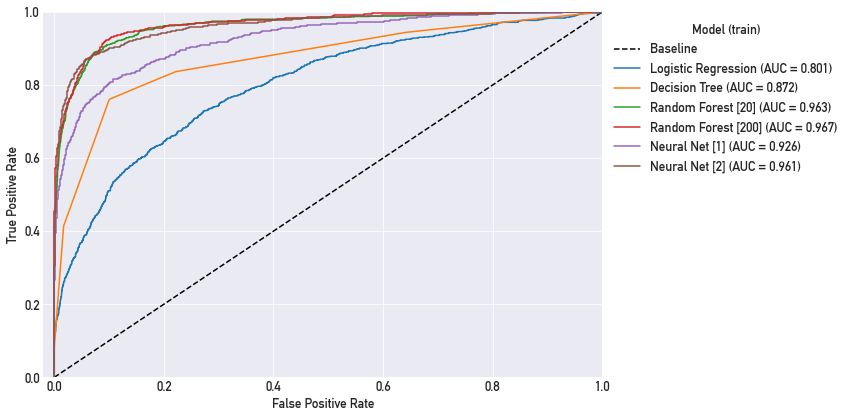

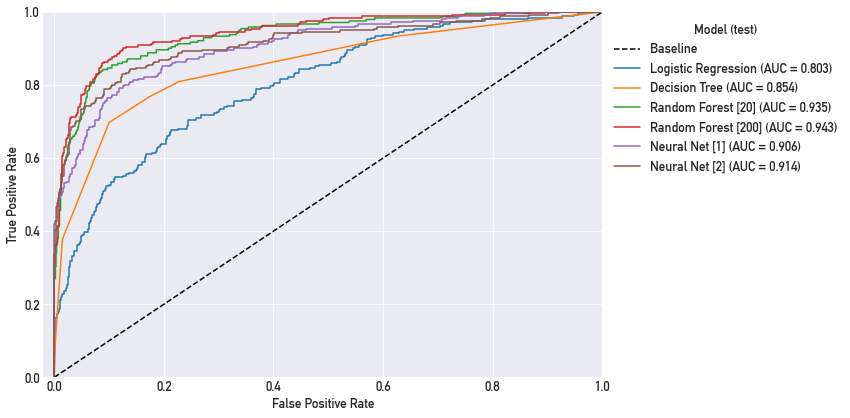

In [68]:
mdls['Neural Net [1]'] = model_1
mdls['Neural Net [2]'] = model_2

# train ROC
plot_roc(x_train, x_train_norm, y_train, mdls, task='6', mode='Train')

# test ROC
plot_roc(x_test, x_test_norm, y_test, mdls, task='6', mode='Test')